## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from tqdm import tqdm


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(512),
            nn.Linear(512, 512),
            nn.Dropout(0.2),
            nn.BatchNorm1d(512),
            nn.ReLU(512),
            nn.Linear(512, 128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.ReLU(128),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
           Dropout-6                  [-1, 512]               0
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
          Dropout-10                  [-1, 128]               0
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 733,834
Trainable params:

Your experiments come here:

In [9]:
def train(dataloader, model, loss_func, optimizer):
    '''Train model'''
    size = len(dataloader.dataset)
    train_loss, correct = 0, 0
    model.train()
    
    for batch_idx, (X_data, y_data) in enumerate(dataloader):
        X_data = X_data.to(device)
        y_data = y_data.to(device)
        
        # Forward
        pred = model(X_data)
        loss = loss_func(pred, y_data)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss_func(pred, y_data).item()
        correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
        
    train_loss /= size
    correct /= size
    
    return correct, train_loss
            
def test(dataloader, model, loss_func):
    '''Test accuracy'''
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X_data, y_data in dataloader:
            X_data = X_data.to(device)
            y_data = y_data.to(device)
            pred = model(X_data)
            test_loss += loss_func(pred, y_data).item()
            correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    
    return correct, test_loss

def plot_data(data: list, title: str, legend: list, xlabel: str, ylabel: str) -> None:
    '''Plot data from list'''
    plt.title(title)
    plt.grid()

    for data_item in data:
        x_range_lst = list(range(len(data_item)))
        plt.plot(x_range_lst, data_item)
        
    plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [10]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [11]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 40
for t in range(epochs):
    train_accuracy, train_loss = train(train_loader, model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(test_loader, model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
        Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

Epoch: 1	Test Accuracy: 80.0%, Test Avg loss: 0.002692	        Train Accuracy: 73.0%, Train Avg loss: 0.007748
Epoch: 2	Test Accuracy: 83.1%, Test Avg loss: 0.002081	        Train Accuracy: 81.9%, Train Avg loss: 0.004566
Epoch: 3	Test Accuracy: 84.3%, Test Avg loss: 0.001862	        Train Accuracy: 84.1%, Train Avg loss: 0.003809
Epoch: 4	Test Accuracy: 85.4%, Test Avg loss: 0.001718	        Train Accuracy: 85.4%, Train Avg loss: 0.003426
Epoch: 5	Test Accuracy: 85.8%, Test Avg loss: 0.001636	        Train Accuracy: 86.4%, Train Avg loss: 0.003171
Epoch: 6	Test Accuracy: 86.4%, Test Avg loss: 0.001567	        Train Accuracy: 86.9%, Train Avg loss: 0.002999
Epoch: 7	Test Accuracy: 86.8%, Test Avg loss: 0.001521	        Train Accuracy: 87.7%, Train Avg loss: 0.002831
Epoch: 8	Test Accuracy: 87.3%, Test Avg loss: 0.001467	        Train Accuracy: 88.1%, Train Avg loss: 0.002710
Epoch: 9	Test Accuracy: 87.6%, Test Avg loss: 0.001424	        Train Accuracy: 88.5%, Train Avg loss: 0.002604
E

In [12]:
test_accuracy = test(test_loader, model, loss_func)
print(f"Accuracy on test: {test_accuracy}")

Accuracy on test: (0.8867, 0.0013808886468410493)


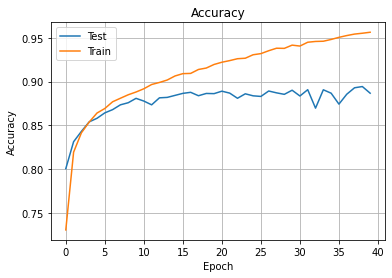

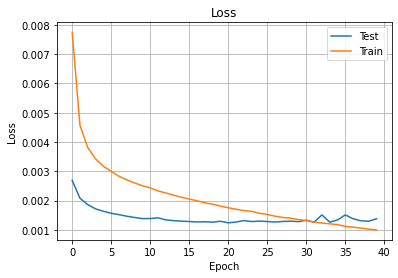

In [13]:
plot_data(
    data=[test_accuracy_lst, train_accuracy_lst],
    title="Accuracy",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Accuracy"
)
plot_data(
    data=[test_loss_lst, train_loss_lst],
    title="Loss",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Loss"
)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Для переобученя модели
1) отключим L2 регуляризацию 
2) Не используем Dropout слои
3) Используем только 0.25 тренировочного датасета
4) Используем модель с большим числом слоев и параметров (выше было показано, что модель может давать желаемый результат и с меньшим числом параметров)

Rem: Слои с Batchnorm пришлось добавить сразу, а не в разделе Fix it, т.к. без них модель очень плохо обучалась.

In [14]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Linear(2048, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [15]:
def train(dataloader, model, loss_func, optimizer):
    '''Train model'''
    max_batch_count = len(dataloader) / 4
    batch_size = 128
    # size = int(batch_size * max_batch_count)
    size = 0
    train_loss, correct = 0, 0
    model.train()
    
    for batch_idx, (X_data, y_data) in enumerate(dataloader):
        if batch_idx >= max_batch_count:
            break
        X_data = X_data.to(device)
        y_data = y_data.to(device)
        
        # Forward
        pred = model(X_data)
        loss = loss_func(pred, y_data)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss_func(pred, y_data).item()
        correct += (pred.argmax(1) == y_data).type(torch.float).sum().item()
        size += pred.shape[0]
        
    train_loss /= size
    correct /= size
    
    return correct, train_loss

In [16]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0)
loss_func = nn.CrossEntropyLoss()

In [17]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
            Linear-5                 [-1, 2048]       2,099,200
       BatchNorm1d-6                 [-1, 2048]           4,096
              ReLU-7                 [-1, 2048]               0
            Linear-8                 [-1, 2048]       4,196,352
       BatchNorm1d-9                 [-1, 2048]           4,096
             ReLU-10                 [-1, 2048]               0
           Linear-11                 [-1, 2048]       4,196,352
      BatchNorm1d-12                 [-1, 2048]           4,096
             ReLU-13                 [-1, 2048]               0
           Linear-14                   

In [18]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 500
for t in tqdm(range(epochs)):
    train_accuracy, train_loss = train(train_loader, model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(test_loader, model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    # print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
    #     Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

100%|██████████| 500/500 [07:35<00:00,  1.10it/s]

Done
CPU times: user 3min 59s, sys: 1min 5s, total: 5min 4s
Wall time: 7min 35s


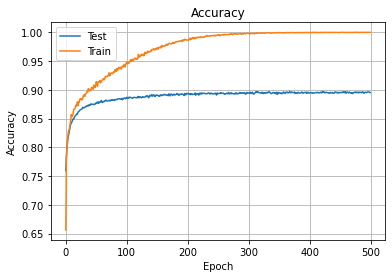

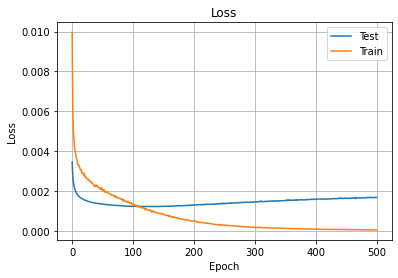

In [19]:
plot_data(
    data=[test_accuracy_lst, train_accuracy_lst],
    title="Accuracy",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Accuracy"
)
plot_data(
    data=[test_loss_lst, train_loss_lst],
    title="Loss",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Loss"
)

Видно, что модельначала переобучаться примерно на 100-й эпохе обучения, т.к. далее Loss на тесте повышался.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

Для исправления переобучения будем
1) Использовать L2 регуляризацию в SGD
2) Использовать Dropout слои
3) Добавим данных в обучающую выборку

Rem: количество слоев и параметров оставляем без изменений, т.к. задача - исправить модель, а не написать новую.

In [20]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(1024),
            nn.Dropout(0.25),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Dropout(0.25),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Dropout(0.25),
            nn.Linear(2048, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(2048),
            nn.Dropout(0.25),
            nn.Linear(2048, num_classes),
        )
        
    def forward(self, inp):       
        return self.model(inp)

In [21]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
       BatchNorm1d-3                 [-1, 1024]           2,048
              ReLU-4                 [-1, 1024]               0
           Dropout-5                 [-1, 1024]               0
            Linear-6                 [-1, 2048]       2,099,200
       BatchNorm1d-7                 [-1, 2048]           4,096
              ReLU-8                 [-1, 2048]               0
           Dropout-9                 [-1, 2048]               0
           Linear-10                 [-1, 2048]       4,196,352
      BatchNorm1d-11                 [-1, 2048]           4,096
             ReLU-12                 [-1, 2048]               0
          Dropout-13                 [-1, 2048]               0
           Linear-14                 [-

In [22]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

In [23]:
%%time

train_loss_lst = []
test_loss_lst = []
train_accuracy_lst = []
test_accuracy_lst = []

epochs = 500
for t in tqdm(range(epochs)):
    train_accuracy, train_loss = train(train_loader, model, loss_func, opt)
    train_accuracy_lst.append(train_accuracy)
    train_loss_lst.append(train_loss)

    test_accuracy, test_loss = test(test_loader, model, loss_func)
    test_accuracy_lst.append(test_accuracy)
    test_loss_lst.append(test_loss)

    # print(f"Epoch: {t+1}\tTest Accuracy: {(100*test_accuracy):>0.1f}%, Test Avg loss: {test_loss:>8f}\t\
    #     Train Accuracy: {(100*train_accuracy):>0.1f}%, Train Avg loss: {train_loss:>8f}", end='\n')
print("Done")

100%|██████████| 500/500 [07:55<00:00,  1.05it/s]

Done
CPU times: user 4min 31s, sys: 1min 5s, total: 5min 37s
Wall time: 7min 55s


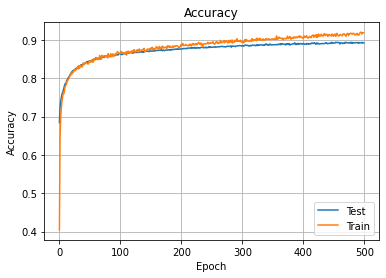

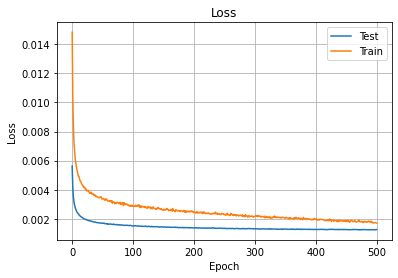

In [24]:
plot_data(
    data=[test_accuracy_lst, train_accuracy_lst],
    title="Accuracy",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Accuracy"
)
plot_data(
    data=[test_loss_lst, train_loss_lst],
    title="Loss",
    legend=["Test", "Train"],
    xlabel="Epoch",
    ylabel="Loss"
)

### Conclusions:

Из графиков выше видно, что после добавления L2 регуляризации, Dropout слоев и новых данных в обучающую выборку эффект переобучения не наблюдается. Показатели Loss на том же количестве эпох не возрастают на тестовой выборке.